# 프로젝트 : CIFAR-10 이미지 생성하기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

BUFFER_SIZE = 50000
BATCH_SIZE = 256

## STEP 1. 작업환경 구성하기
* 생성된 이미지와 모델 체크포인트, 훈련 시각화 그래프를 저장할 폴더를 각각 준비합니다.

## STEP 2. 데이터셋 구성하기

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

In [3]:
print(train_x[1])

[[[154 177 187]
  [126 137 136]
  [105 104  95]
  ...
  [ 91  95  71]
  [ 87  90  71]
  [ 79  81  70]]

 [[140 160 169]
  [145 153 154]
  [125 125 118]
  ...
  [ 96  99  78]
  [ 77  80  62]
  [ 71  73  61]]

 [[140 155 164]
  [139 146 149]
  [115 115 112]
  ...
  [ 79  82  64]
  [ 68  70  55]
  [ 67  69  55]]

 ...

 [[175 167 166]
  [156 154 160]
  [154 160 170]
  ...
  [ 42  34  36]
  [ 61  53  57]
  [ 93  83  91]]

 [[165 154 128]
  [156 152 130]
  [159 161 142]
  ...
  [103  93  96]
  [123 114 120]
  [131 121 131]]

 [[163 148 120]
  [158 148 122]
  [163 156 133]
  ...
  [143 133 139]
  [143 134 142]
  [143 133 144]]]


In [4]:
#데이터를 정규화해줍니다.
print(train_x.max())
print(train_x.min())
# 정규화 0~1 or -1~1
train_x = (train_x-127.5)/127.5
#train_x = (train_x)/255
print(train_x.max())
print(train_x.min())

255
0
1.0
-1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


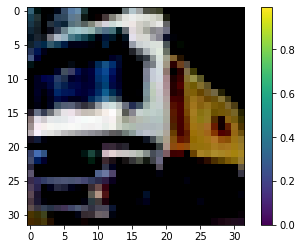

In [5]:
plt.imshow(train_x[1])
plt.colorbar()
plt.show()

* 정규화 상쇄 코드입니다.

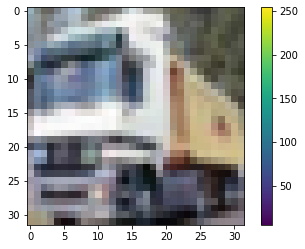

In [6]:
train_x_re = train_x*127.5+127.5
train_x_re = train_x_re.astype(np.int16)
plt.imshow(train_x_re[1])
plt.colorbar()
plt.show()
#print(train_x_re[1])

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 3. 생성자 모델 구현
* 32X32X3의 출력 벡터를 가지는 생성자를 구현합니다.
* 32X32X3의 이미지 벡터를 출력하기 위해 input layer를 8X8X256으로 설정합니다.(개선된 현재는 16X16X128)
* 또한, RGB 이미지이기 때문에 output layer의 depth를 3으로 설정합니다.

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(16*16*128,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((16,16,128)))
    
    model.add(layers.Conv2D(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(3, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, \
                                     activation='tanh'))
    
    return model

In [9]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             3276800   
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0

#### 가우시안 분포로 뽑아낸 랜덤 벡터입니다

In [10]:
noise = tf.random.normal([1,100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.7709228 , -0.2302061 ,  0.50850266, -0.7158778 ,  0.69249105,
         0.18256404, -0.99314165,  0.69575804, -0.3695374 ,  0.5033718 ,
        -1.3827858 ,  1.0490614 , -1.2927616 ,  0.5327214 ,  1.0343349 ,
        -1.0653297 ,  0.9171173 ,  1.0763676 ,  1.348491  ,  1.2610873 ,
        -0.16571225,  1.0747058 , -0.39826322, -0.40038928, -0.18904401,
        -1.0530704 , -0.39883038, -0.37467113, -0.95461166, -1.7272756 ,
         0.8016997 , -0.08876645, -1.0295857 , -0.1886553 , -0.5509756 ,
        -1.3933687 , -1.234786  ,  0.63419634,  1.8158058 , -1.8407623 ,
         1.0310166 ,  2.2676568 ,  1.2576823 ,  0.25795844,  1.1884893 ,
        -1.3883855 , -2.479509  , -1.3465852 ,  0.341042  , -1.7486031 ,
        -0.39882374,  0.8103269 , -0.6629955 , -0.87019   , -0.6834905 ,
        -0.48785055, -0.24998033,  1.963767  , -0.83992153,  0.0162173 ,
        -0.02375383,  2.040633  ,  0.32201943,  1.8632165 , -0.6915011 ,
 

In [11]:
generated_image = generator(noise)
print(generated_image[0].shape)

(32, 32, 3)


* 이미지가 크기에 맞게 잘 생성되었습니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


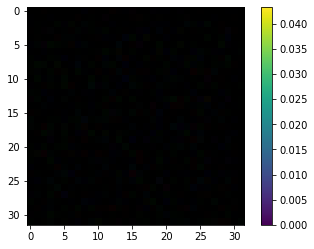

In [12]:
plt.imshow(generated_image[0, :, :, :])
plt.colorbar()
plt.show()

## STEP 4. 판별자 모델 구현
* 진짜 또는 가짜 이미지가 입력으로 들어오면 진짜라고 판단하는 정도를 출력해야 합니다.
* 따라서 입력은 32X32X3의 이미지, 출력은 하나의 숫자가 됩니다.

In [13]:
def make_discriminator_model():
    
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1,activation='sigmoid'))

    return model

In [14]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)        

#### 생성한 이미지를 넣어봅시다.

In [15]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4997586]], dtype=float32)>

* 아직은 아무런 의미가 없는 숫자를 출력합니다.

## STEP 5. 손실함수와 최적화 함수 구현
* 학습의 목표는 생성자는 판별자가 fake_img에 대해 판별한 값이 1에 가까워지도록, 판별자는 real_img의 판별값은 1에 fake_img의 판별값은 0에 가까워지도록 하는 것입니다.
* 이 목표에 맞춰 loss와 optimizer를 구현합니다.

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### generator loss

In [17]:
#생성자는 판별값이 1에 가까워야 함
#판별값이 1에 가까울수록 작은값을 반환
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

#### discriminator loss

In [18]:
#real에 대한 loss와 fake에 대한 loss를 각각 구해 더한 값을 최종 loss
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss+fake_loss
    return total_loss

#### discriminator accuracy
* 인자를 이용해 사진을 정확히 판별했을수록 정확도가 1에 가까워집니다.

In [19]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

#### optimizer
* Adam을 이용해 optimizer를 구현합니다.
* learning rate를 다양한 값으로 바꿔가며 학습을 진행하도록 합니다.
* 생성자와 구분자는 따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어줍니다.

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0001)

## STEP 6. 훈련 상세기능 구현

In [21]:
#샘플을 한번에 16장 생성합니다.
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

#### 학습
* 한번 학습시 실행될 함수
* 데코레이터 @tf.function 을 사용하면 함수에 입력된 인자가 tf의 graph의 노드가 될 수 있는 값으로 자동변환됩니다.

In [22]:
def train_step(images):  #(1) 입력데이터
    #(2) 생성자 입력 노이즈
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  
    #(3) tf.GradientTape() 오픈
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #(4) generated_images 생성
        generated_images = generator(noise, training=True)  

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습 : 모델의 훈련 가능한 가중치를 모두 갱신
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

#### 이미지 생성 후 저장

In [23]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

#### epoch마다 그래프를 그리고 이미지 저장

In [24]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

#### model checkpoint 저장

In [25]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 7. 학습 과정 진행하기

In [26]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [27]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

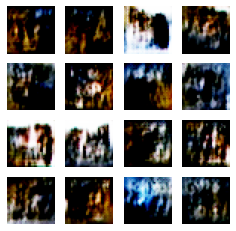

Time for training : 13228 sec


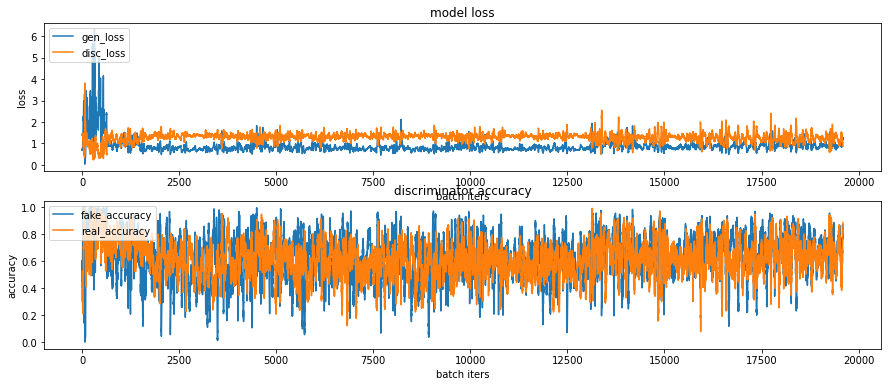

CPU times: user 1h 19min 14s, sys: 7min 48s, total: 1h 27min 2s
Wall time: 3h 40min 29s


In [28]:
%%time
train(train_dataset, EPOCHS, save_every)

In [30]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_dcgan1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

## STEP 8. GAN 훈련과정 개선하기
#### 초기 모델의 학습 과정입니다.
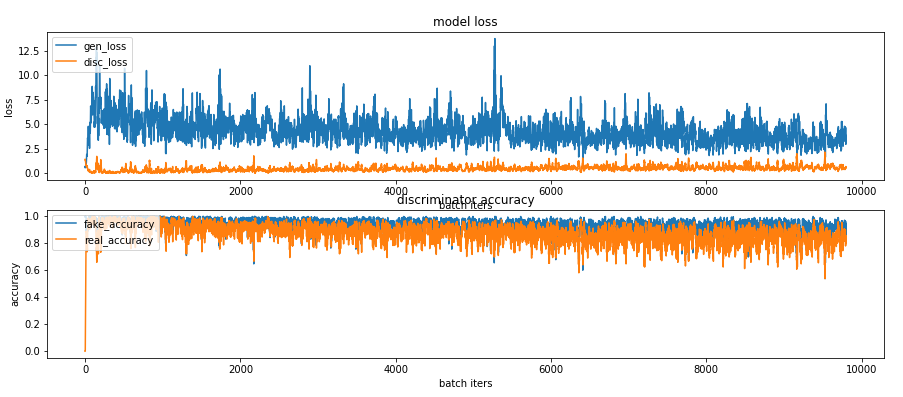  
* 과정을 통해 알수있는 점은 판별자가 예측을 매우 정확히 하지만 생성자는 그에 맞춰 제대로된 학습을 하지 못하는 것을 볼 수 있습니다.  

#### 생성자 개선
생성자의 출력 크기를 유지하며 레이어를 좀 더 깊게 쌓아봤습니다.
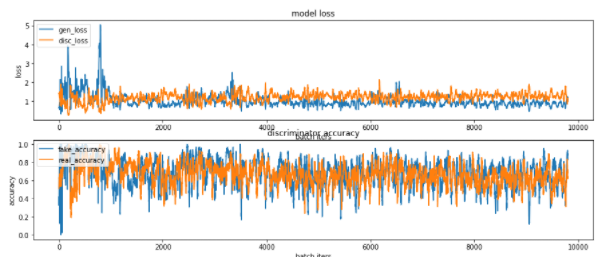  
* loss가 크게 낮아졌고 정확도도 어느정도 개선된 모습을 보이지만 아직 편차가 큽니다.

#### 판별자 개선
이번에는 판별자의 레이어를 좀 더 깊게 쌓고 dropout rate를 0.5로 올려주었습니다.
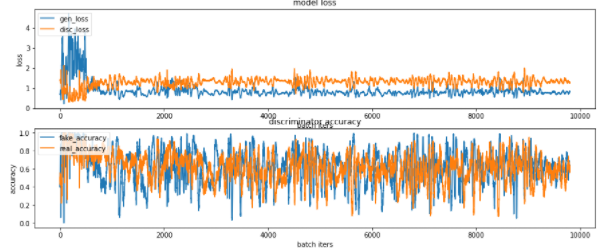
* 정확도가 0.5정도에 좀 더 모인것을 볼 수 있습니다.  

#### 이미지 개선과정
![cifar_dcgan1.gif](https://github.com/winrinseo/simple_deep/blob/master/%5BE-10%5Dcifar_dcgan1.gif?raw=true)

# 회고합시다
* 흑백 이미지보다 channel 수가 많다보니 생성되는 이미지도 크게 알아보기는 힘듭니다.